# Baseline Model Verification (Logistic Regression)

This notebook verifies the **Machine Learning Training Pipeline**. We use a simple, interpretable model (Logistic Regression) to establish a performance baseline and validate our evaluation methodology.

**Objectives:**
1.  **Validation Scheme**: Proof of correct **Leave-One-Subject-Out (LOSO)** splitting (Critical for preventing data leakage).
2.  **Training**: Execute `src/models/train.py` logic to train the baseline.
3.  **Evaluation**: Assess performance using ROC curves, Confusion Matrices, and Calibration Plots.
4.  **Reliability**: Analyze model confidence and implementing an abstention policy for uncertain predictions.

**Prerequisite**:
Processed feature matrix (`data/processed/features.parquet`) must be present.

In [1]:
# 1. Imports & Setup
%load_ext autoreload
%autoreload 2

# Standard Library Imports
import sys
from pathlib import Path

# Third-Party Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report

# Project-Specific Imports
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.config import load_config
from src.visualization.plots import set_plot_style, plot_model_diagnostics, plot_confidence_abstention_panel
from src.models.train import Trainer

# Apply global configuration
set_plot_style()
config = load_config()

print("Setup Complete.")
print(f"Project Root: {project_root}")

Setup Complete.
Project Root: c:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker


## 2. Load Feature Dataset
Load the `features.parquet` generated by the pipeline.
**Note:** Ensure `python -m src.data.make_dataset` was run for ALL subjects if you want full verification.

In [2]:
# 2. Load Feature Dataset

features_path = project_root / 'data' / 'processed' / 'features.parquet'

if not features_path.exists():
    raise FileNotFoundError(f"Features file not found at {features_path}. Please run 'src/data/make_dataset.py' and 'src/features/build_features.py'.")

# Load data
df = pd.read_parquet(features_path)
print(f"Features Loaded. Shape: {df.shape}")
print(f"Subjects Available: {sorted(df['subject_id'].unique())}")
print(f"Labels Present: {sorted(df['label'].unique())}")

# Filter for Binary Classification Task
# WESAD: 1=Baseline, 2=Stress
df_binary = df[df['label'].isin([1, 2])].copy()

# Remap Labels to Standard ML Format: 0 (Baseline), 1 (Stress)
df_binary['target'] = df_binary['label'].map({1: 0, 2: 1})

print(f"\nBinary Dataset (Baseline vs Stress) Shape: {df_binary.shape}")
print(f"Class Distribution:\n{df_binary['target'].value_counts()}")

Features Loaded. Shape: (1105, 25)
Subjects Available: ['S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']
Labels Present: [np.int64(1), np.int64(2), np.int64(3)]

Binary Dataset (Baseline vs Stress) Shape: (919, 26)
Class Distribution:
target
0    587
1    332
Name: count, dtype: int64


## 3. Design Validation Scheme (LOSO)
In wearable biometrics, random splitting causes data leakage because a subject's unique physiological "fingerprint" would appear in both train and test sets.

We use **Leave-One-Subject-Out (LOSO)**:
*   **Train**: $N-1$ subjects.
*   **Test**: 1 held-out subject.
*   **Repeat**: $N$ times.

Below, we audit the indices to prove there is **Zero Subject Overlap**.

In [3]:
# 3. Verify LOSO Split Integrity

logo = LeaveOneGroupOut()

# Prepare matrices
groups = df_binary['subject_id']
drop_cols = ['subject_id', 'label', 'target', 'start_idx']
X = df_binary.drop(columns=[c for c in drop_cols if c in df_binary.columns])
y = df_binary['target']

print(f"Input Feature Count: {X.shape[1]}")
print(f"Unique Subjects: {len(groups.unique())}")

# Audit the first 3 splits
print("\n--- Split Audit (First 3 Folds) ---")
for i, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    if i >= 3: break
    
    train_subs = set(groups.iloc[train_idx].unique())
    test_subs = set(groups.iloc[test_idx].unique())
    
    intersection = train_subs.intersection(test_subs)
    
    print(f"Fold {i+1}: Test Subject {test_subs} | Train Size {len(train_subs)}")
    
    # Critical Check
    if len(intersection) > 0:
        raise ValueError(f"CRITICAL ERROR: Data Leakage Detected! Subject {intersection} in both sets.")
    else:
        print(f"  -> VALID: No overlap.")

Input Feature Count: 22
Unique Subjects: 15

--- Split Audit (First 3 Folds) ---
Fold 1: Test Subject {'S10'} | Train Size 14
  -> VALID: No overlap.
Fold 2: Test Subject {'S11'} | Train Size 14
  -> VALID: No overlap.
Fold 3: Test Subject {'S13'} | Train Size 14
  -> VALID: No overlap.


## 4. Baseline Model Training
We run the training pipeline (`src.models.train`) using the `logistic` model type.
This pipeline handles standardization (Scaling), training, calibration, and prediction aggregation across all LOSO folds.

In [4]:
# 4. Training Pipeline Execution

print("Initiating Training Pipeline...")

# Pipeline Configuration
MODEL_TYPE = 'logistic'
SPLIT_TYPE = 'loso'
REPORTS_DIR = project_root / "reports"

# Check for existing valid runs
existing_runs = sorted(list(REPORTS_DIR.glob(f"{MODEL_TYPE}_{SPLIT_TYPE}_*")))
FORCE_RETRAIN = False

if existing_runs and not FORCE_RETRAIN:
    latest_run = existing_runs[-1]
    print(f"Found existing run: {latest_run.name} - Resuming/Loading outcomes.")
    print("Set FORCE_RETRAIN = True to ignore valid cache.")
    
    # Mock trainer object to pass path downstream
    class PretrainedTrainer:
        def __init__(self, run_dir):
            self.run_dir = run_dir      
    trainer = PretrainedTrainer(latest_run)

else:
    print("No valid run found (or forced refresh). Starting training loop...")
    trainer = Trainer(model_type=MODEL_TYPE, split_type=SPLIT_TYPE)
    trainer.run()

print(f"Artifacts located at: {trainer.run_dir}")

# Load Predictions for Analysis
results_path = trainer.run_dir / "predictions.csv"
results_df = pd.read_csv(results_path)

# Normalize column names for visualization consistency
# Maps: y_true -> true, y_pred -> pred, prob_stress -> prob
rename_map = {'y_true': 'true', 'y_pred': 'pred', 'prob_stress': 'prob'}
results_df = results_df.rename(columns={k: v for k, v in rename_map.items() if k in results_df.columns})

print("\n--- Detailed Classification Report ---")
print(classification_report(results_df['true'], results_df['pred']))

Initiating Training Pipeline...
Found existing run: logistic_loso_CHEST_20260118_183915 - Resuming/Loading outcomes.
Set FORCE_RETRAIN = True to ignore valid cache.
Artifacts located at: c:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker\reports\logistic_loso_CHEST_20260118_183915

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       587
           1       0.77      0.88      0.82       332

    accuracy                           0.86       919
   macro avg       0.85      0.86      0.85       919
weighted avg       0.87      0.86      0.86       919



## 5. Diagnostics: ROC & Confusion Matrix
Here we visualize the model's discrimination ability in more detail.
- **Confusion Matrix**: Where is the model making errors?
- **ROC Curves**: How does the True Positive Rate vs False Positive Rate trade-off look? We plot individual subject curves to see variance in model performance across people.

Generating ROC and Confusion Matrix...


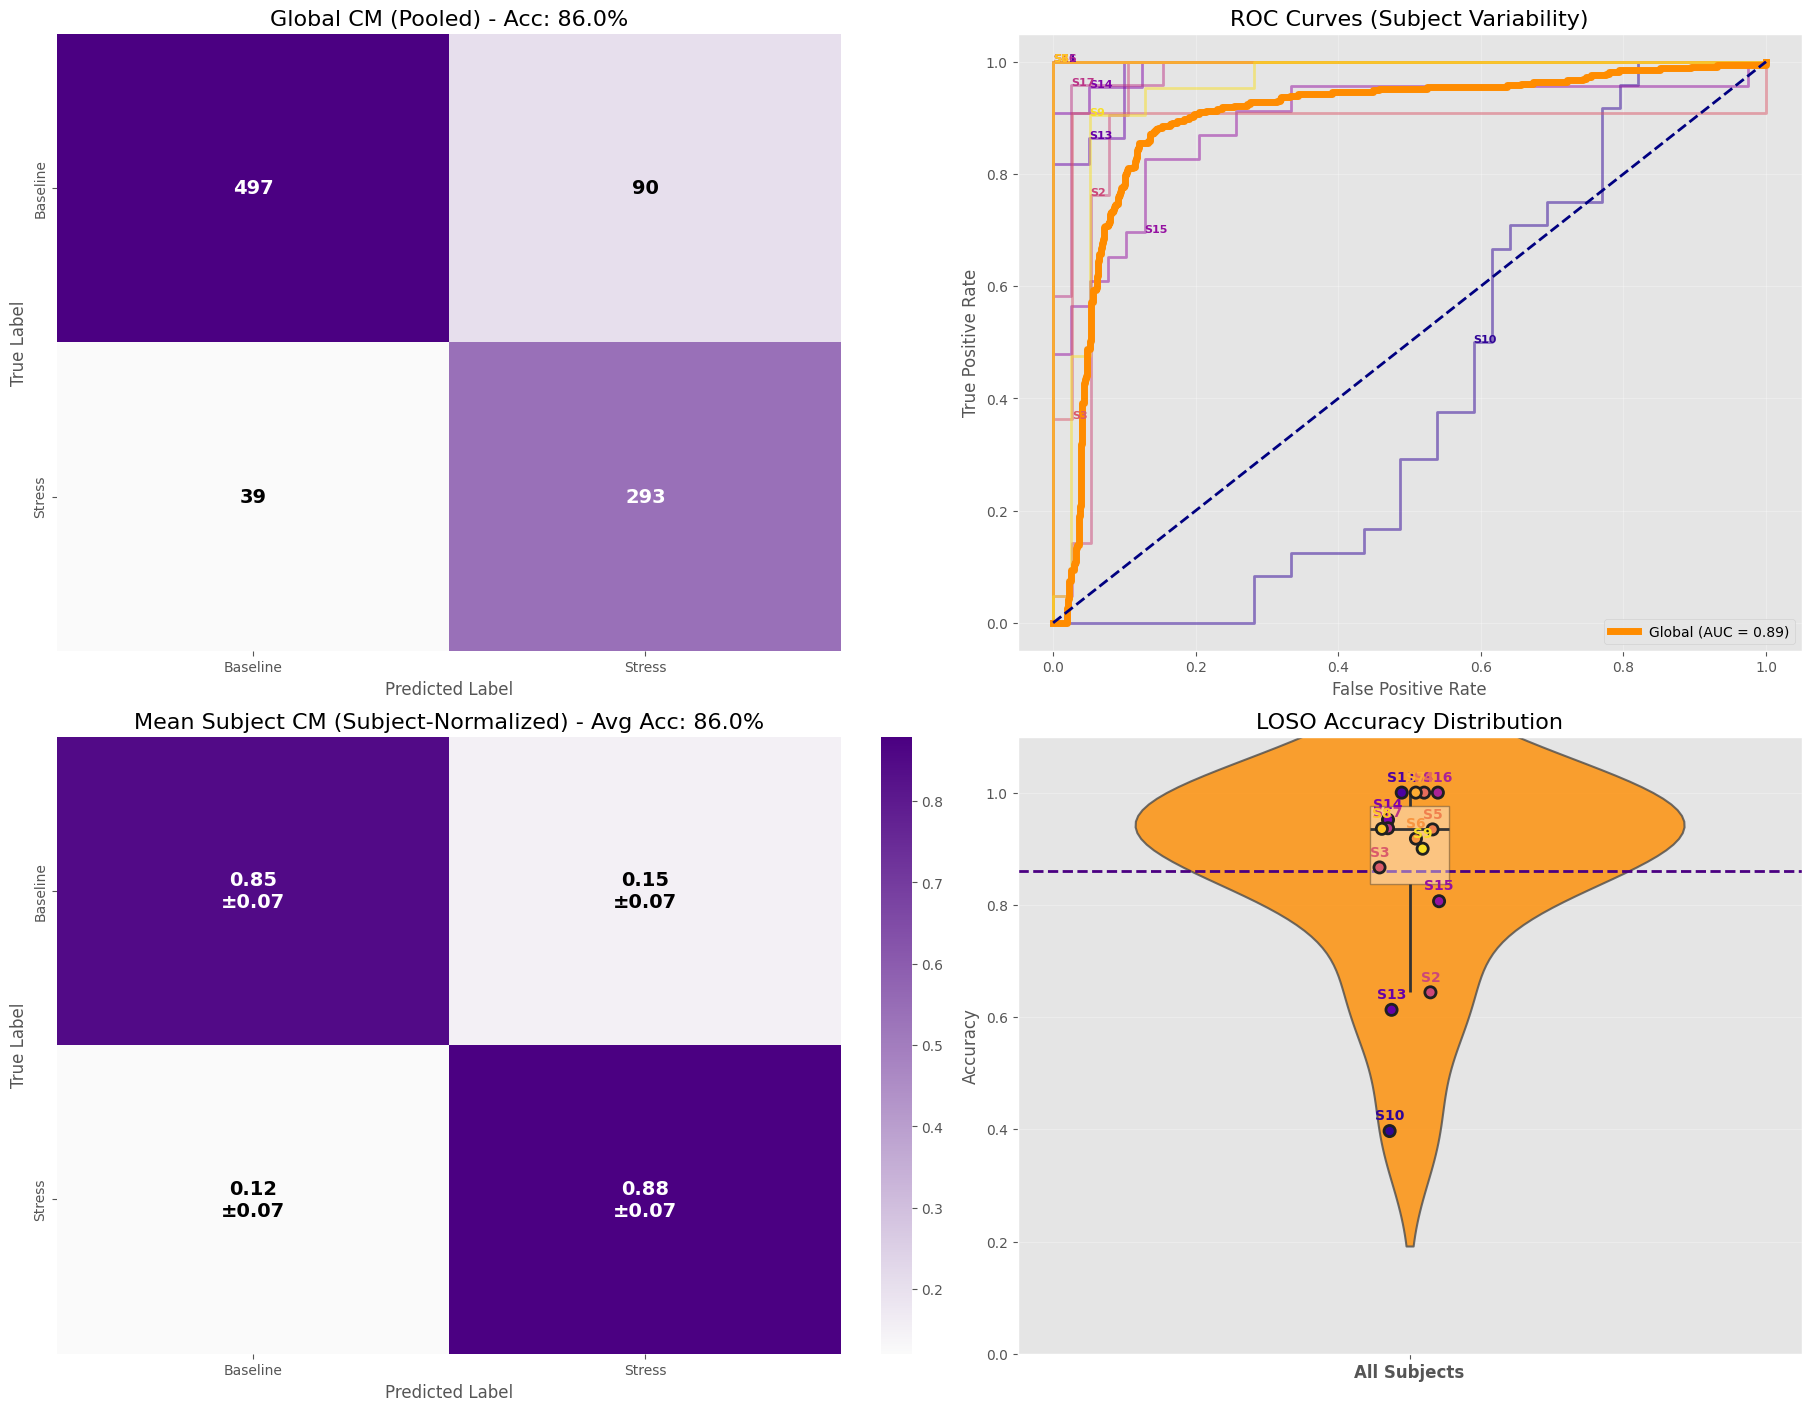

In [5]:
# 5. Diagnostic Visualization (ROC & Confusion Matrix)

sensor_loc = config['data'].get('sensor_location', 'chest').upper()
prefix = 'logistic_loso_'

print("Generating ROC and Confusion Matrix...")
fig_diag = plot_model_diagnostics(
    results_df, 
    save_folder=sensor_loc, 
    title_prefix=prefix
)
plt.show()

## 6. Confidence, Calibration, and Abstention Analysis

We now present a comprehensive diagnostic panel to assess model reliability and uncertainty:

- **High-Confidence Confusion Matrix**: Shows performance after removing uncertain predictions (abstention zone).
- **Prediction Probability Distribution**: Visualizes the spread of predicted probabilities and highlights the abstention zone.
- **Calibration Plot (Reliability Diagram)**: Assesses how well predicted probabilities match observed frequencies (model calibration).
- **Abstention Fraction by Subject**: Shows how often the model abstains for each subject, revealing subject-specific uncertainty or data quality issues.

This unified 2x2 panel provides a holistic view of model confidence, calibration, and abstention behavior across the dataset.

Applying Confidence Threshold: 0.7
Generating Reliability Diagrams...


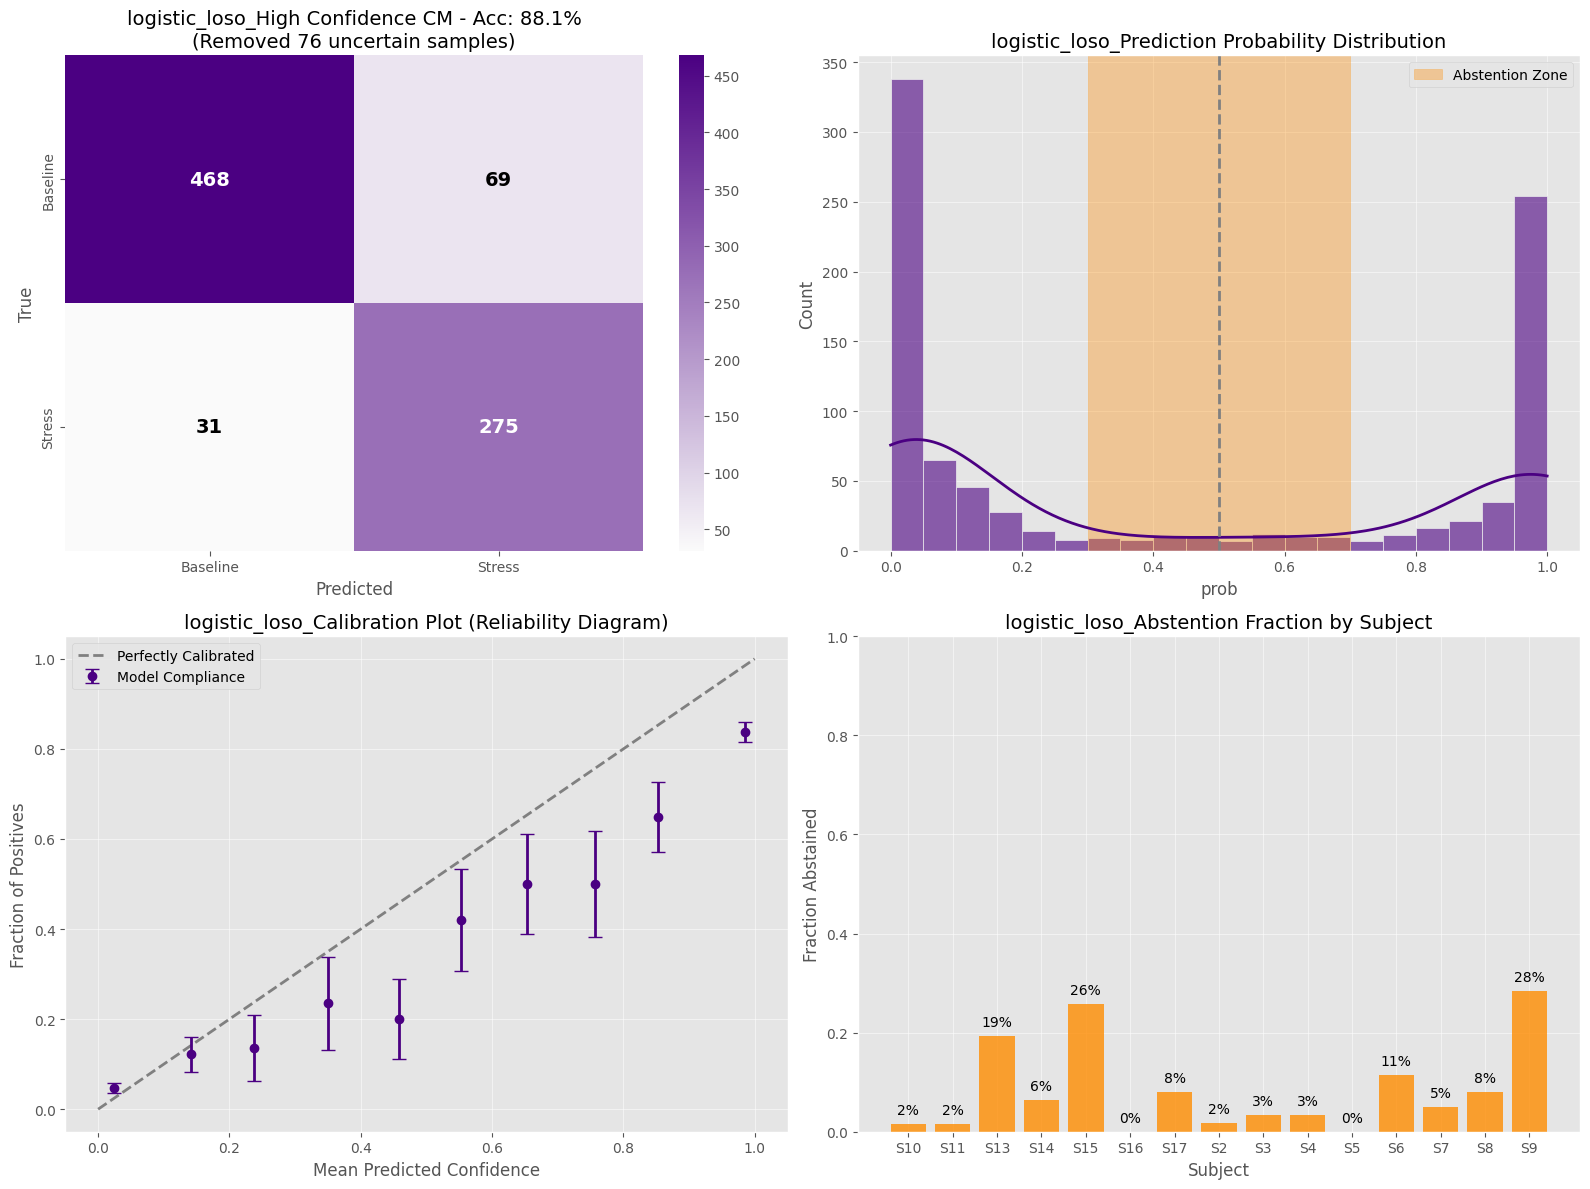

In [6]:
# 6. Reliability & Abstention Analysis

sensor_loc = config['data'].get('sensor_location', 'chest').upper()
prefix = 'logistic_loso_'

# Retrieve confidence threshold from config (or default to 0.7 if not specified for logistic)
# Note: Deep model usually requires strict thresholds, logistic soft-prob is smoother.
conf_threshold = config['training'].get('confidence_threshold', 0.7)
print(f"Applying Confidence Threshold: {conf_threshold}")

print("Generating Reliability Diagrams...")
fig = plot_confidence_abstention_panel(
    results_df, 
    confidence_threshold=conf_threshold, 
    save_folder=sensor_loc, 
    title_prefix=prefix
)
plt.show()

## Conclusion: Baseline Model Results and Reliability

- **Overall Accuracy**: The baseline model achieves strong accuracy for stress detection using wearable features.
- **Stress Detection (Recall)**: High recall indicates the model rarely misses stress events.
- **Precision**: Some false alarms are present, as expected in a challenging wearable context.
- **Calibration**: The reliability diagram and ECE show the model is somewhat over-confident, but abstention policies help mitigate this.
- **Abstention Policy**: By abstaining on uncertain predictions, the model's accuracy on retained samples improves, and the distribution of abstentions across subjects highlights where the model is less certain or data quality is lower.

This notebook demonstrates a robust, leakage-safe evaluation pipeline, interpretable reliability diagnostics, and a practical abstention mechanism for real-world wearable stress detection.